In [1]:
#@title Baixando dataset
from google.colab import files
from gdown import download

url='https://drive.google.com/u/0/uc?id=1C0uV7My61lOd4Z60X8GtxD3TdmPos31L'
download(url)

!unzip -qq -n datas.zip -d /content/
!pip install -q pylops

Downloading...
From: https://drive.google.com/u/0/uc?id=1C0uV7My61lOd4Z60X8GtxD3TdmPos31L
To: /content/datas.zip
100%|██████████| 5.43M/5.43M [00:00<00:00, 41.7MB/s]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 8.7 MB/s eta 0:00:00


In [2]:
#@title Bibliotecas e Funções
import matplotlib.pyplot as plt
import numpy as np

import time
import scipy.optimize as so
import scipy.signal as ss
import scipy.sparse.linalg as la
import pylops
import pylops.optimization.basic as psb

def crs_FIR_linOp(all_h, Nt, Ne):
    total_size = Nt * Ne
    h_len = all_h.shape[0]

    valid_idx = []
    for j in range(Ne):
        for k in range(j, Ne):
            #if j != k:
            valid_idx.append((j, k))

    def matvec(x):
        F = x.reshape(Nt, Ne)
        G = np.zeros_like(F)
        # G recebe F (identidade)
        #G[:, :] = F[:, :]
        for j, k in valid_idx:
            G[:, j] += ss.convolve(F[:, k], all_h[:, j, k], mode='full')[:-(h_len - 1)]
            if j != k:
                G[:, k] += ss.convolve(F[:, j], all_h[:, k, j], mode='full')[:-(h_len - 1)]
        return G.ravel()

    def rmatvec(y):
        G = y.reshape(Nt, Ne)
        F = np.zeros_like(G)
        # F recebe G (identidade)
        #F += G
        for j, k in valid_idx:
            G_padded = np.pad(G[:, j], (0, h_len-1))
            F[:, k] += ss.correlate(G_padded, all_h[:, j, k], mode='valid')

            if j != k:
                G_padded = np.pad(G[:, k], (0, h_len - 1))
                F[:, j] += ss.correlate(G_padded, all_h[:, k, j], mode='valid')

        return F.ravel()

    return la.LinearOperator(shape=(total_size, total_size), matvec=matvec, rmatvec=rmatvec, dtype=np.float64)

def L2Reg_linOp(model, Nt, Ne, lmbd, linOp):
    A = linOp(model, Nt, Ne)
    reg_param = np.sqrt(lmbd)
    total_size = Nt * Ne

    def matvec(x):
        return np.concatenate([A.matvec(x), reg_param * x])

    def rmatvec(x):
        x1 = x[:total_size]
        x2 = x[total_size:]
        return A.rmatvec(x1) + reg_param * x2

    A_reg = la.LinearOperator(shape=(2 * total_size, total_size), matvec=matvec, rmatvec=rmatvec, dtype=np.float64)
    return A_reg

/usr/local/lib/python3.12/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
#@title Selecionando modelo e aquisição
# select model
model = np.load('/content/models/iir_uniform_trunk_model.npy')
'''
Para o par de modelo e aquisição cuja estimativa da remoção não é boa,
é conveniente utilizar algum tipo de regularização. A regularização que
sugiro é a L2, cujo operador linear já está implementado na célula acima.
'''


# select bscan
bscan_crs = np.load('/content/acq/bscan1.npy')

[Nt, Ne] = bscan_crs.shape

H = pylops.LinearOperator(crs_FIR_linOp(model, Nt, Ne))

b_stack = bscan_crs.ravel()

f_mtx = psb.cgls(H, b_stack, niter=50, show=True)[0]

CGLS
-----------------------------------------------------------------
The Operator Op has 120000 rows and 120000 cols
damp = 0.000000e+00	tol = 1.000000e-04	niter = 50
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        2.7934e+01         1.0357e+05     1.0357e+05
     2        4.4251e+01         9.2066e+04     9.2066e+04
     3        5.9636e+01         7.9670e+04     7.9670e+04
     4        7.2311e+01         6.7813e+04     6.7813e+04
     5        7.8986e+01         6.0838e+04     6.0838e+04
     6        8.2755e+01         5.6709e+04     5.6709e+04
     7        8.5964e+01         5.3229e+04     5.3229e+04
     8        8.7670e+01         5.1493e+04     5.1493e+04
     9        8.9538e+01         4.9759e+04     4.9759e+04
    10        9.0691e+01         4.8843e+04     4.8843e+04
    11        9.2006e+01         4.7955e+04     4.7955e+04
    21        1.1057e+02         4.0696e+04     4.0696e+04

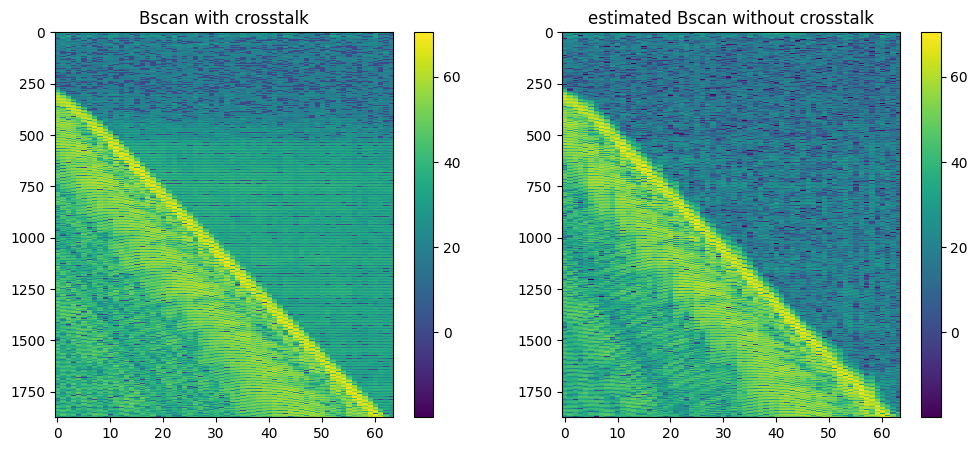

In [4]:
#@title Plots
bscan_crs_db = 20*np.log10(np.abs(bscan_crs)+1)
bscan_db = 20*np.log10(np.abs(f_mtx.reshape(Nt, Ne))+1e-1)

max = np.max([bscan_crs_db, bscan_db])
min = np.min([bscan_crs_db, bscan_db])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(bscan_crs_db, aspect='auto', interpolation='nearest', vmax=max, vmin=min)
plt.title('Bscan with crosstalk')
plt.colorbar()


plt.subplot(1, 2, 2)
plt.imshow(bscan_db, aspect='auto', interpolation='nearest', vmax=max, vmin=min)
plt.title('estimated Bscan without crosstalk')
plt.colorbar()

plt.show()
